In [9]:
## requiremnts
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install torch torchvision opencv-python numpy

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ofzxzzgh
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ofzxzzgh
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=a74aeb1149f9709989898c7e8d15f9606a630c6acf4d1eba393cb16d107edf85
  Stored in directory: /tmp/pip-ephem-wheel-cache-puvfh4fh/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [13]:
## create sam predictor
import os
from segment_anything import SamPredictor,sam_model_registry
model_path='./sam_vit_b_01ec64.pth'
if not os.path.exists(model_path):
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
sam = sam_model_registry["vit_b"](checkpoint=model_path)
predictor = SamPredictor(sam)


--2024-03-07 13:52:47--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.33, 13.227.219.10, 13.227.219.59, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   197MB/s    in 1.8s    

2024-03-07 13:52:49 (197 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [14]:
## load image and select x and y coordinates to test
import cv2

image_path = './test.jpg'
if not os.path.exists(image_path):
  !wget https://utils-computervisiondeveloper.s3.amazonaws.com/media/public/test.jpg

x=528
y=606
image=cv2.imread(image_path)

--2024-03-07 14:02:37--  https://utils-computervisiondeveloper.s3.amazonaws.com/media/public/test.jpg
Resolving utils-computervisiondeveloper.s3.amazonaws.com (utils-computervisiondeveloper.s3.amazonaws.com)... 52.217.132.169, 54.231.229.145, 52.217.48.116, ...
Connecting to utils-computervisiondeveloper.s3.amazonaws.com (utils-computervisiondeveloper.s3.amazonaws.com)|52.217.132.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79560 (78K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  77.70K   454KB/s    in 0.2s    

2024-03-07 14:02:38 (454 KB/s) - ‘test.jpg’ saved [79560/79560]



In [15]:
# use sam predictor on the image,x,y to get location of subject
import numpy as np
predictor.set_image(image)

masks,scores,logits=predictor.predict(
    point_coords=np.asarray([[x,y]]),
    point_labels=np.asarray([1]),
    multimask_output=True
)

C,H,W=masks.shape

result_mask=np.zeros((H,W),dtype=bool)

for j in range(C):
  result_mask |=masks[j,:,:]

result_mask=result_mask.astype(np.uint8)

In [6]:
#remove background
alpha_channel=np.ones(result_mask.shape,dtype=result_mask.dtype)*255

alpha_channel[result_mask==0]=0

result_image=cv2.merge((image,alpha_channel))

In [16]:
#wrap it up as function
def remove_background(image,x,y):
  predictor.set_image(image)
  masks,scores,logits=predictor.predict(
      point_coords=np.asarray([[x,y]]),
      point_labels=np.asarray([1]),
      multimask_output=True
  )

  C,H,W=masks.shape

  result_mask=np.zeros((H,W),dtype=bool)

  for j in range(C):
    result_mask |=masks[j,:,:]

  result_mask=result_mask.astype(np.uint8)
  alpha_channel=np.ones(result_mask.shape,dtype=result_mask.dtype)*255

  alpha_channel[result_mask==0]=0

  result_image=cv2.merge((image,alpha_channel))
  return result_image

In [17]:
result=remove_background(image,x,y)

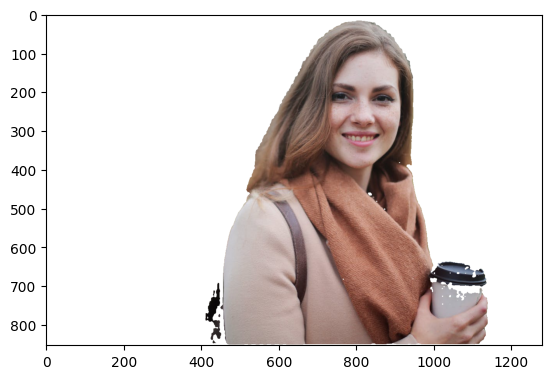

In [20]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGRA2RGBA))
plt.show()